In [17]:
import pandas as pd 
import numpy as np 
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import sys
import operator
import argparse
%matplotlib inline
df1=pd.read_csv('../input/tmdb-movie-metadata/tmdb_5000_credits.csv')
df2=pd.read_csv('../input/tmdb-movie-metadata/tmdb_5000_movies.csv')
df1.columns = ['id','tittle','cast','crew']
df2= df2.merge(df1,on='id')
df2.head(5)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,tittle,cast,crew
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


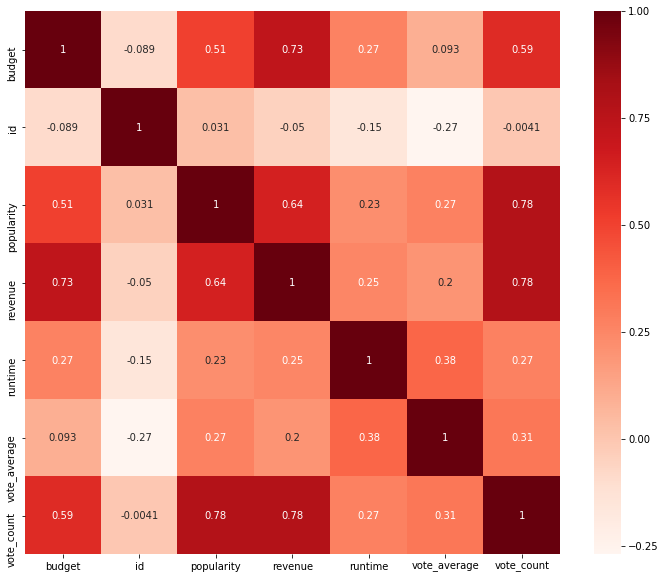

In [18]:
#Using Pearson Correlation
plt.figure(figsize=(12,10))
cor = df2.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [19]:
#Correlation with output variable
cor_target = abs(cor["popularity"])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.5]
relevant_features

budget        0.505414
popularity    1.000000
revenue       0.644724
vote_count    0.778130
Name: popularity, dtype: float64

**Demographic Filtering**
Using weighted rating 
(v/v+m)*R + (m/v+m)*C
where,

v is the number of votes for the movie;
m is the minimum votes required to be listed in the chart;
R is the average rating of the movie; And
C is the mean vote across the whole report

We already have v(vote_count) and R (vote_average) and C can be calculated as

In [20]:
C= df2['vote_average'].mean()
C

6.092171559442011

So, the mean rating for all the movies is approx 6 on a scale of 10.The next step is to determine an appropriate value for m, the minimum votes required to be listed in the chart. We will use 90th percentile as our cutoff. In other words, for a movie to feature in the charts, it must have more votes than at least 90% of the movies in the list.

In [21]:
m= df2['vote_count'].quantile(0.9)
m

1838.4000000000015

Now, we can filter out the movies that qualify for the chart

In [22]:
q_movies = df2.copy().loc[df2['vote_count'] >= m]
q_movies.shape

(481, 23)

We see that there are 481 movies which qualify to be in this list. Now, we need to calculate our metric for each qualified movie. To do this, we will define a function, weighted_rating() and define a new feature score, of which we'll calculate the value by applying this function to our DataFrame of qualified movies:

In [23]:
def weighted_rating(x, m=m, C=C):
    v = x['vote_count']
    R = x['vote_average']
    # Calculation based on the IMDB formula
    return (v/(v+m) * R) + (m/(m+v) * C)

define a new feature score, and calculate it based on weighted_rating

In [24]:
q_movies['score'] = q_movies.apply(weighted_rating, axis=1)

Finally, let's sort the DataFrame based on the score feature and output the title, vote count, vote average and weighted rating or score of the top 10 movies.

In [25]:
q_movies = q_movies.sort_values('score', ascending=False)

#Print the top 15 movies
q_movies[['title', 'vote_count', 'vote_average', 'score']].head(10)

,title,vote_count,vote_average,score
1881,The Shawshank Redemption,8205,8.5,8.059258
662,Fight Club,9413,8.3,7.939256
65,The Dark Knight,12002,8.2,7.920020
3232,Pulp Fiction,8428,8.3,7.904645
96,Inception,13752,8.1,7.863239
3337,The Godfather,5893,8.4,7.851236
95,Interstellar,10867,8.1,7.809479
809,Forrest Gump,7927,8.2,7.803188
329,The Lord of the Rings: The Return of the King,8064,8.1,7.727243
1990,The Empire Strikes Back,5879,8.2,7.697884


Text(0.5,1,'Popular Movies')

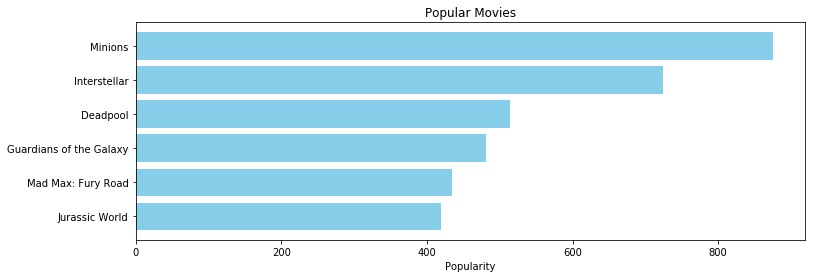

In [26]:
pop= df2.sort_values('popularity', ascending=False)
import matplotlib.pyplot as plt
plt.figure(figsize=(12,4))

plt.barh(pop['title'].head(6),pop['popularity'].head(6), align='center',
        color='skyblue')
plt.gca().invert_yaxis()
plt.xlabel("Popularity")
plt.title("Popular Movies")

**Contenent based filtering**

In this recommender system the content of the movie (overview, cast, crew, keyword, tagline etc) is used to find its similarity with other movies. Then the movies that are most likely to be similar are recommended.

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer

#Define a TF-IDF Vectorizer Object. Remove all english stop words such as 'the', 'a'
tfidf = TfidfVectorizer(stop_words='english')

#Replace NaN with an empty string
df2['overview'] = df2['overview'].fillna('')

#Construct the required TF-IDF matrix by fitting and transforming the data
tfidf_matrix = tfidf.fit_transform(df2['overview'])

#Output the shape of tfidf_matrix
tfidf_matrix.shape

(4803, 20978)

to calculate simmilarity out of TF-IDF, we will use sklearn cosine,Since we have used the TF-IDF vectorizer, calculating the dot product will directly give us the cosine similarity score. Therefore, we will use sklearn's linear_kernel() instead of cosine_similarities() since it is faster.

In [28]:
# Import linear_kernel
from sklearn.metrics.pairwise import linear_kernel

# Compute the cosine similarity matrix
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [29]:
#Construct a reverse map of indices and movie titles
indices = pd.Series(df2.index, index=df2['title']).drop_duplicates()

We are now in a good position to define our recommendation function. These are the following steps we'll follow :-

Get the index of the movie given its title.
Get the list of cosine similarity scores for that particular movie with all movies. Convert it into a list of tuples where the first element is its position and the second is the similarity score.
Sort the aforementioned list of tuples based on the similarity scores; that is, the second element.
Get the top 10 elements of this list. Ignore the first element as it refers to self (the movie most similar to a particular movie is the movie itself).
Return the titles corresponding to the indices of the top elements.

In [30]:
# Function that takes in movie title as input and outputs most similar movies
def get_recommendations(title, cosine_sim=cosine_sim):
    # Get the index of the movie that matches the title
    idx = indices[title]

    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:11]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    return df2['title'].iloc[movie_indices]

In [31]:
get_recommendations('The Dark Knight Rises')

65                              The Dark Knight
299                              Batman Forever
428                              Batman Returns
1359                                     Batman
3854    Batman: The Dark Knight Returns, Part 2
119                               Batman Begins
2507                                  Slow Burn
9            Batman v Superman: Dawn of Justice
1181                                        JFK
210                              Batman & Robin
Name: title, dtype: object

In this recommendations it's only based on the movie title, next we will inhance it to caputer more features.

In [32]:
from ast import literal_eval

features = ['cast', 'crew', 'keywords', 'genres']
for feature in features:
    df2[feature] = df2[feature].apply(literal_eval)

In [33]:
# Get the director's name from the crew feature. If director is not listed, return NaN
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

In [34]:
# Returns the list top 3 elements or entire list; whichever is more.
def get_list(x):
    if isinstance(x, list):
        names = [i['name'] for i in x]
        #Check if more than 3 elements exist. If yes, return only first three. If no, return entire list.
        if len(names) > 3:
            names = names[:3]
        return names

    #Return empty list in case of missing/malformed data
    return []

In [35]:
# Define new director, cast, genres and keywords features that are in a suitable form.
df2['director'] = df2['crew'].apply(get_director)

features = ['cast', 'keywords', 'genres']
for feature in features:
    df2[feature] = df2[feature].apply(get_list)

In [36]:
# Print the new features of the first 3 films
df2[['title', 'cast', 'director', 'keywords', 'genres']].head(3)

,title,cast,director,keywords,genres
0,Avatar,"[Sam Worthington, Zoe Saldana, Sigourney Weaver]",James Cameron,"[culture clash, future, space war]","[Action, Adventure, Fantasy]"
1,Pirates of the Caribbean: At World's End,"[Johnny Depp, Orlando Bloom, Keira Knightley]",Gore Verbinski,"[ocean, drug abuse, exotic island]","[Adventure, Fantasy, Action]"
2,Spectre,"[Daniel Craig, Christoph Waltz, Léa Seydoux]",Sam Mendes,"[spy, based on novel, secret agent]","[Action, Adventure, Crime]"


In [37]:
# Function to convert all strings to lower case and strip names of spaces
def clean_data(x):
    if isinstance(x, list):
        return [str.lower(i.replace(" ", "")) for i in x]
    else:
        #Check if director exists. If not, return empty string
        if isinstance(x, str):
            return str.lower(x.replace(" ", ""))
        else:
            return ''

In [38]:
features = ['cast', 'keywords', 'director', 'genres']

for feature in features:
    df2[feature] = df2[feature].apply(clean_data)

In [39]:
def create_soup(x):
    return ' '.join(x['keywords']) + ' ' + ' '.join(x['cast']) + ' ' + x['director'] + ' ' + ' '.join(x['genres'])
df2['soup'] = df2.apply(create_soup, axis=1)

In [40]:
# Import CountVectorizer and create the count matrix
from sklearn.feature_extraction.text import CountVectorizer

count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(df2['soup'])

In [41]:
# Compute the Cosine Similarity matrix based on the count_matrix
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim2 = cosine_similarity(count_matrix, count_matrix)
# Reset index of our main DataFrame and construct reverse mapping as before
df2 = df2.reset_index()
indices = pd.Series(df2.index, index=df2['title'])

In [42]:
get_recommendations('The Dark Knight Rises', cosine_sim2)

65               The Dark Knight
119                Batman Begins
4638    Amidst the Devil's Wings
1196                The Prestige
3073           Romeo Is Bleeding
3326              Black November
1503                      Takers
1986                      Faster
303                     Catwoman
747               Gangster Squad
Name: title, dtype: object

We see that our recommender has been successful in capturing more information due to more metadata and has given us (arguably) better recommendations. It is more likely that Marvels or DC comics fans will like the movies of the same production house. Therefore, to our features above we can add production_company . We can also increase the weight of the director , by adding the feature multiple times in the soup.

**Collaborative Filtering**

Now enough said , let's see how to implement this. Since the dataset we used before did not have userId(which is necessary for collaborative filtering) let's load another dataset. We'll be using the Surprise library to implement SVD.

In [43]:
from surprise import Reader, Dataset, SVD, evaluate
reader = Reader()
ratings = pd.read_csv('../input/the-movies-dataset/ratings_small.csv')
ratings.columns = ['userId', 'id', 'rating','timestamp']
ratings.head()


,userId,id,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


Merging the two datasets together, based on the movie id

In [44]:
ratings=ratings.merge(df2,on='id')

**collaborative filtering model ** (User,Items)

After loading the dataset, we should look at the content of each file (users, ratings, items).

In [45]:
import pandas as pd
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

# pass in column names for each CSV as the column name is not given in the file and read them using pandas.
# You can check the column names from the readme file

#Reading users file:
u_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv('../input/movielens-100k-dataset/ml-100k/u.user', sep='|', names=u_cols,encoding='latin-1')

#Reading ratings file:
r_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv('../input/movielens-100k-dataset/ml-100k/u.data', sep='\t', names=r_cols,encoding='latin-1')

#Reading items file:
i_cols = ['movie id', 'movie title' ,'release date','video release date', 'IMDb URL', 'unknown', 'Action', 'Adventure',
'Animation', 'Children\'s', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
items = pd.read_csv('../input/movielens-100k-dataset/ml-100k/u.item', sep='|', names=i_cols,
encoding='latin-1')

In [46]:
print(users.shape)
users.head()

(943, 5)


,user_id,age,sex,occupation,zip_code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


In [47]:
print(ratings.shape)
ratings.head()

(100000, 4)


,user_id,movie_id,rating,unix_timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [48]:
print(items.shape)
items.head()

(1682, 24)


,movie id,movie title,release date,video release date,IMDb URL,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


The dataset has already been divided into train and test by GroupLens where the test data has 10 ratings for each user, i.e. 9,430 rows in total. We will read both these files into our Python environment.

In [49]:
r_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings_train = pd.read_csv('../input/movielens-100k-dataset/ml-100k/ua.base', sep='\t', names=r_cols, encoding='latin-1')
ratings_test = pd.read_csv('../input/movielens-100k-dataset/ml-100k/ua.test', sep='\t', names=r_cols, encoding='latin-1')
ratings_train.shape, ratings_test.shape

((90570, 4), (9430, 4))

Building Model:

Recommending movies based on items, and users

In [50]:
n_users = ratings.user_id.unique().shape[0]
n_items = ratings.movie_id.unique().shape[0]

Building user-item matrix for calculating the similarity, using Cosine distance

In [51]:
data_matrix = np.zeros((n_users, n_items))
for line in ratings.itertuples():
    data_matrix[line[1]-1, line[2]-1] = line[3]
    from sklearn.metrics.pairwise import pairwise_distances 
user_similarity = pairwise_distances(data_matrix, metric='cosine')
item_similarity = pairwise_distances(data_matrix.T, metric='cosine')

Using item-item, user-user arrays, we will build our recommendation engine

In [52]:
def predict(ratings, similarity, type='user'):
    if type == 'user':
        mean_user_rating = ratings.mean(axis=1)
        #We use np.newaxis so that mean_user_rating has same format as ratings
        ratings_diff = (ratings - mean_user_rating[:, np.newaxis])
        pred = mean_user_rating[:, np.newaxis] + similarity.dot(ratings_diff) / np.array([np.abs(similarity).sum(axis=1)]).T
    elif type == 'item':
        pred = ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])
    return pred

Similarity between the users, and items

In [53]:
user_prediction = predict(data_matrix, user_similarity, type='user')
item_prediction = predict(data_matrix, item_similarity, type='item')
print(user_prediction)


[[ 2.06532606  0.73430275  0.62992381 ...  0.39359041  0.39304874
   0.3927712 ]
 [ 1.76308836  0.38404019  0.19617889 ... -0.08837789 -0.0869183
  -0.08671183]
 [ 1.79590398  0.32904733  0.15882885 ... -0.13699223 -0.13496852
  -0.13476488]
 ...
 [ 1.59151513  0.27526889  0.10219534 ... -0.16735162 -0.16657451
  -0.16641377]
 [ 1.81036267  0.40479877  0.27545013 ... -0.00907358 -0.00846587
  -0.00804858]
 [ 1.8384313   0.47964837  0.38496292 ...  0.14686675  0.14629808
   0.14641455]]


In [54]:
from surprise import Reader, Dataset, SVD, evaluate
reader = Reader()
data = Dataset.load_from_df(ratings_train[['user_id', 'movie_id', 'rating']], reader)
data.split(n_folds=5)
svd = SVD()
evaluate(svd, data, measures=['RMSE', 'MAE'])

/opt/conda/lib/python3.6/site-packages/surprise/evaluate.py:66: UserWarning: The evaluate() method is deprecated. Please use model_selection.cross_validate() instead.
  'model_selection.cross_validate() instead.', UserWarning)
/opt/conda/lib/python3.6/site-packages/surprise/dataset.py:193: UserWarning: Using data.split() or using load_from_folds() without using a CV iterator is now deprecated. 
  UserWarning)


Evaluating RMSE, MAE of algorithm SVD.

------------
Fold 1
RMSE: 0.9427
MAE:  0.7421
------------
Fold 2
RMSE: 0.9313
MAE:  0.7343
------------
Fold 3
RMSE: 0.9352
MAE:  0.7372
------------
Fold 4
RMSE: 0.9381
MAE:  0.7418
------------
Fold 5
RMSE: 0.9413
MAE:  0.7406
------------
------------
Mean RMSE: 0.9377
Mean MAE : 0.7392
------------
------------


CaseInsensitiveDefaultDict(list,
                           {'rmse': [0.9426529652059613,
                             0.9313170233471819,
                             0.9352213992507978,
                             0.9381138691077792,
                             0.941284183626061],
                            'mae': [0.7420906703293797,
                             0.734265281160479,
                             0.737161632195484,
                             0.7417930205801674,
                             0.740579040870913]})

RMSE = 0.93, which is more than good to have, we choose SVD to validate, as it provides an easy validation with k-folds..

In [56]:
svd.predict(10, 31, 2.5)

Prediction(uid=10, iid=31, r_ui=2.5, est=3.9573138968952253, details={'was_impossible': False})

In [57]:
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
from surprise import Reader, Dataset, SVD, evaluate
md = pd. read_csv('../input/the-movies-dataset/movies_metadata.csv')
md.head()
links_small = pd.read_csv('../input/the-movies-dataset/links_small.csv')
links_small = links_small[links_small['tmdbId'].notnull()]['tmdbId'].astype('int')
md = md.drop([19730, 29503, 35587])
#Check EDA Notebook for how and why I got these indices.
md['id'] = md['id'].astype('int')
smd = md[md['id'].isin(links_small)]
smd.shape
smd['tagline'] = smd['tagline'].fillna('')
smd['description'] = smd['overview'] + smd['tagline']
smd['description'] = smd['description'].fillna('')

smd = smd.reset_index()
titles = smd['title']
indices = pd.Series(smd.index, index=smd['title'])
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(smd['description'])
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
def convert_int(x):
    try:
        return int(x)
    except:
        return np.nan

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3018: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarn

In [58]:
id_map = pd.read_csv('../input/the-movies-dataset/links_small.csv')[['movieId', 'tmdbId']]
id_map['tmdbId'] = id_map['tmdbId'].apply(convert_int)
id_map.columns = ['movieId', 'id']
id_map = id_map.merge(smd[['title', 'id']], on='id').set_index('title')
#id_map = id_map.set_index('tmdbId')

In [59]:
indices_map = id_map.set_index('id')

In [60]:

def hybrid(userId, title):
    idx = indices[title]
    tmdbId = id_map.loc[title]['id']
    #print(idx)
    movie_id = id_map.loc[title]['movieId']
    
    sim_scores = list(enumerate(cosine_sim[int(idx)]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:26]
    movie_indices = [i[0] for i in sim_scores]
    
    movies = smd.iloc[movie_indices][['title', 'vote_count', 'vote_average', 'id']]
    movies['est'] = movies['id'].apply(lambda x: svd.predict(userId, indices_map.loc[x]['movieId']).est)
    movies = movies.sort_values('est', ascending=False)
    return movies.head(10)

In [61]:
hybrid(1, 'Ambush')

,title,vote_count,vote_average,id,est
7587,The American,488.0,5.8,27579,3.450526
5710,The Unknown Soldier,19.0,7.8,36439,3.450526
1615,The Incredible Journey,22.0,6.3,37969,3.450526
7736,Battle: Los Angeles,1462.0,5.5,44943,3.450526
3962,The Bad News Bears,100.0,7.0,23479,3.450526
2459,Tora! Tora! Tora!,150.0,6.9,11165,3.450526
7092,Che: Part One,209.0,6.8,8881,3.450526
5512,Biggles,18.0,5.1,22976,3.450526
7460,Green Zone,730.0,6.4,22972,3.450526
2667,Cross of Iron,89.0,6.6,10839,3.450526


In [67]:
x = hybrid(500, 'Avatar')
x

,title,vote_count,vote_average,id,est
538,Hellraiser: Bloodline,111.0,4.9,8766,4.207415
2059,The Matrix,9079.0,7.9,603,3.297470
4804,Avalon,93.0,6.8,10881,3.297470
1437,Species II,161.0,4.5,10216,3.297470
4643,"Heaven Knows, Mr. Allison",27.0,6.8,37103,3.297470
4328,Dog Soldiers,227.0,6.7,11880,3.297470
6882,Semi-Pro,255.0,5.4,13260,3.297470
2854,The Hidden,85.0,6.7,12476,3.297470
7763,Hanna,1284.0,6.5,50456,3.297470
7050,Pride and Glory,243.0,6.3,13150,3.297470


Applying AutoML:

In [ ]:
from tpot import TPOTClassifier
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

digits = load_digits()
X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target, train_size=0.75, test_size=0.25)

pipeline_optimizer = TPOTClassifier(generations=5, population_size=20, cv=5,
                                    random_state=42, verbosity=2)
pipeline_optimizer.fit(X_train, y_train)
print(pipeline_optimizer.score(X_test, y_test))

Using pickle to export the model to executable package for API deployment.  
The flask app will be accessed via port 5000.

In [68]:
import pickle
#pickle.dump(q_movies, open("/notebook/flask_app/recommendations_system.pkl", "wb"))
#mrs_model = pickle.load(open("/notebook/flask_app/recommendations_system.pkl", "rb"))
#mrs_model

pickle.dump(x, open("/notebook/flask_app/recommendations_system.pkl", "wb"))
mrs_model = pickle.load(open("/notebook/flask_app/recommendations_system.pkl", "rb"))
mrs_model

,title,vote_count,vote_average,id,est
538,Hellraiser: Bloodline,111.0,4.9,8766,4.207415
2059,The Matrix,9079.0,7.9,603,3.297470
4804,Avalon,93.0,6.8,10881,3.297470
1437,Species II,161.0,4.5,10216,3.297470
4643,"Heaven Knows, Mr. Allison",27.0,6.8,37103,3.297470
4328,Dog Soldiers,227.0,6.7,11880,3.297470
6882,Semi-Pro,255.0,5.4,13260,3.297470
2854,The Hidden,85.0,6.7,12476,3.297470
7763,Hanna,1284.0,6.5,50456,3.297470
7050,Pride and Glory,243.0,6.3,13150,3.297470
